In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install statsmodels

In [3]:
import statsmodels


from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA


from datetime import datetime

In [4]:
df = pd.read_excel('/content/us_macro_quarterly.xlsx')

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [5]:
df.head()

,Unnamed: 0,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
0,1957:01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1,1957:02,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
2,1957:03,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333
3,1957:04,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000
4,1958:01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667


In [6]:
def parse_date(data):

  year, quarter = data.split(':')
  month = (int(quarter) - 1)*3+1
  s = f"{year}-{month}"

  return datetime.strptime(s, '%Y-%m')

In [7]:
df['Date'] = df['Unnamed: 0'].apply(parse_date)

In [8]:
df.head()

,Unnamed: 0,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL,Date
0,1957:01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667,1957-01-01
1,1957:02,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333,1957-04-01
2,1957:03,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333,1957-07-01
3,1957:04,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000,1957-10-01
4,1958:01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667,1958-01-01


In [9]:
df.set_index(df['Date'], inplace = True)
df.drop(['Date', 'Unnamed: 0'], axis = 1, inplace=True)

In [10]:
df.index_freq = 'QS'

In [11]:
df.head()

,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
Date,,,,,,,,,
1957-01-01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1957-04-01,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
1957-07-01,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333
1957-10-01,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000
1958-01-01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667


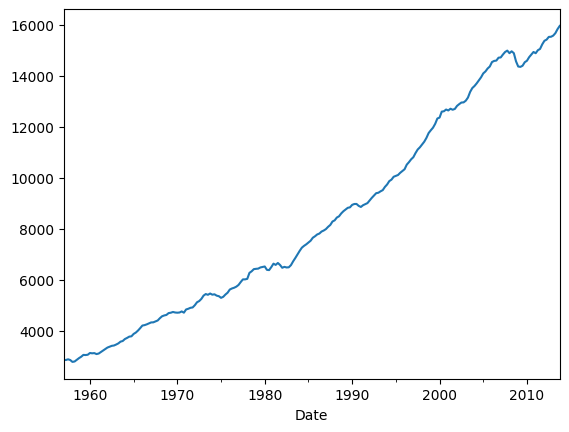

In [12]:
df["GDPC96"].plot();

In [13]:
df['GDPGrowth']= np.log(df['GDPC96']).diff()

In [14]:
df['Tspread'] = df['GS10'] - df['TB3MS']

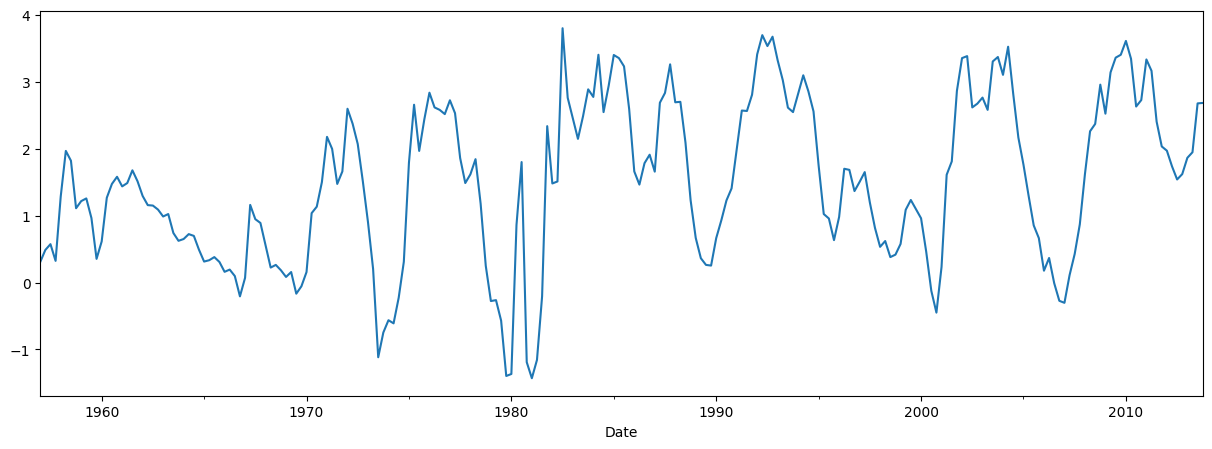

In [15]:
df['Tspread'].plot(figsize = (15,5));

In [16]:
 cols = ['GDPGrowth', 'Tspread']

In [17]:
df1 = df[1:][cols].copy()

In [18]:
Ntest = 12

train = df1.iloc[:-Ntest].copy().dropna()
test = df1.iloc[-Ntest:].copy().dropna()

In [19]:
train_idx = df1.index <= train.index[-1]
test_idx = df1.index > train.index[-1]

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train[cols] = scaler.fit_transform(train)
test[cols] = scaler.transform(test)

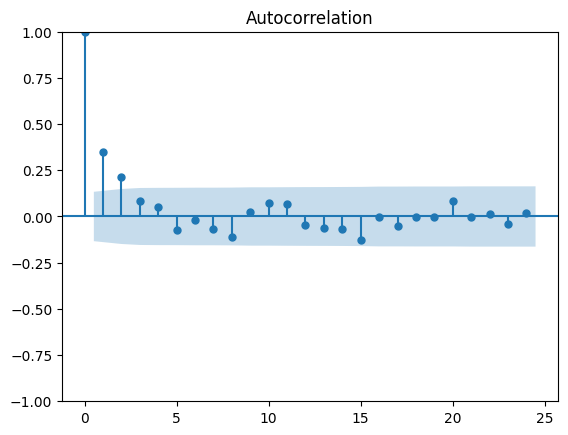

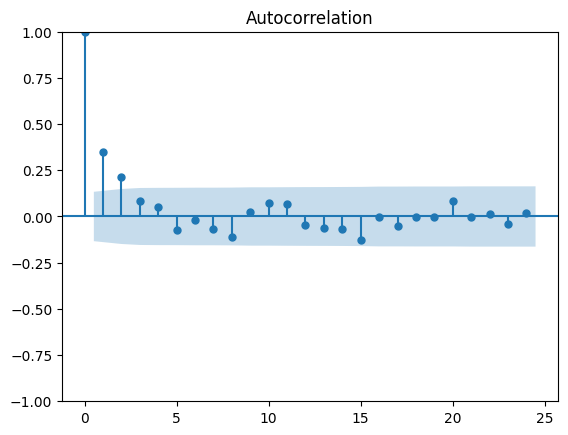

In [21]:
plot_acf(train['GDPGrowth'])

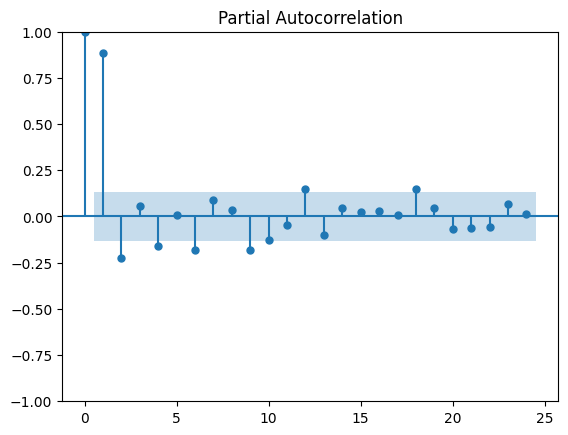

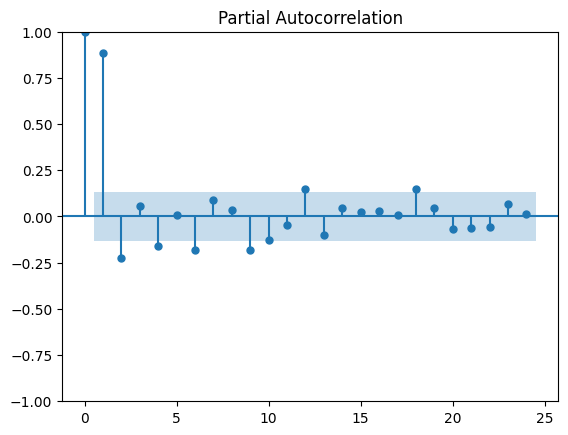

In [22]:
plot_pacf(train['Tspread'])

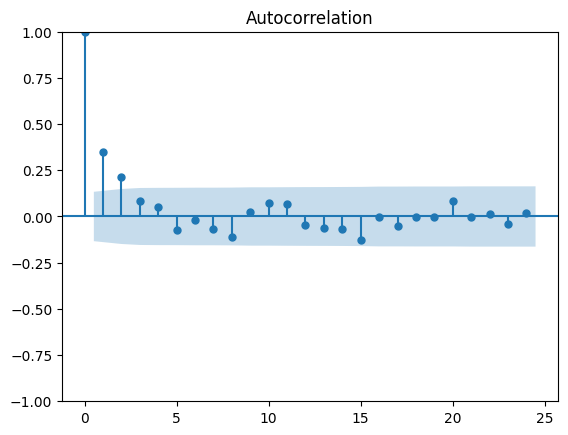

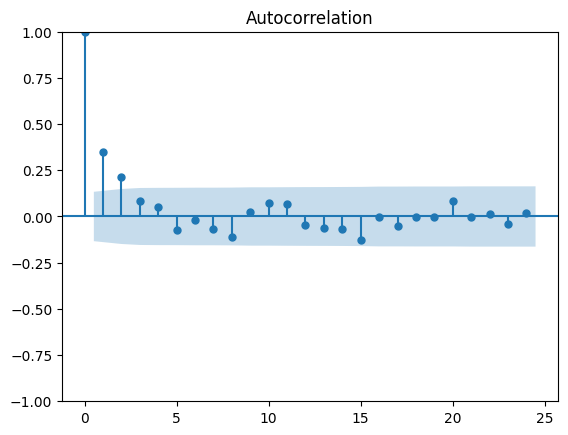

In [23]:
plot_acf(train['GDPGrowth'])

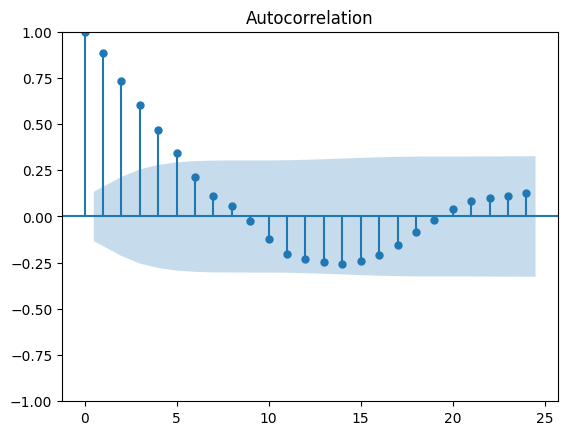

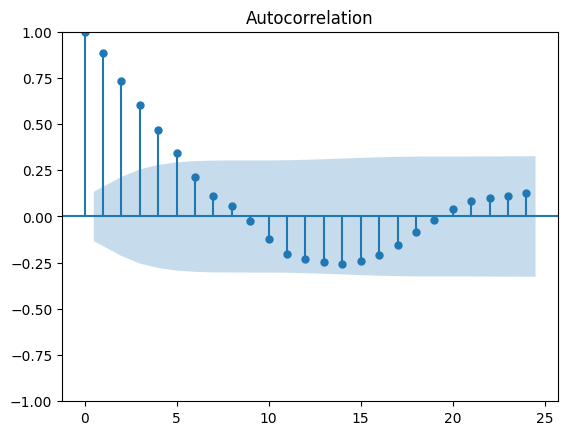

In [24]:
plot_acf(train['Tspread'])

In [25]:
adfuller(train['GDPGrowth'])

(-7.44663965462558,
 5.814896580913866e-11,
 1,
 213,
 {'1%': -3.461429147102264,
  '5%': -2.875206950587861,
  '10%': -2.5740544497344002},
 512.854231063742)

In [26]:
adfuller(train['Tspread'])

(-4.001020795475584,
 0.001405175490749345,
 12,
 202,
 {'1%': -3.4631437906252636,
  '5%': -2.8759570379821047,
  '10%': -2.574454682874228},
 246.36949884218734)

In [27]:
p = 18
q = 1

In [28]:
t0 = datetime.now()

model = VARMAX(train, order = (q, p))
res = model.fit(maxiter = 100)

print("Duration : ", datetime.now() - t0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duration :  0:02:22.464808


In [29]:
fcast = res.get_forecast(Ntest)

<Axes: xlabel='Date'>

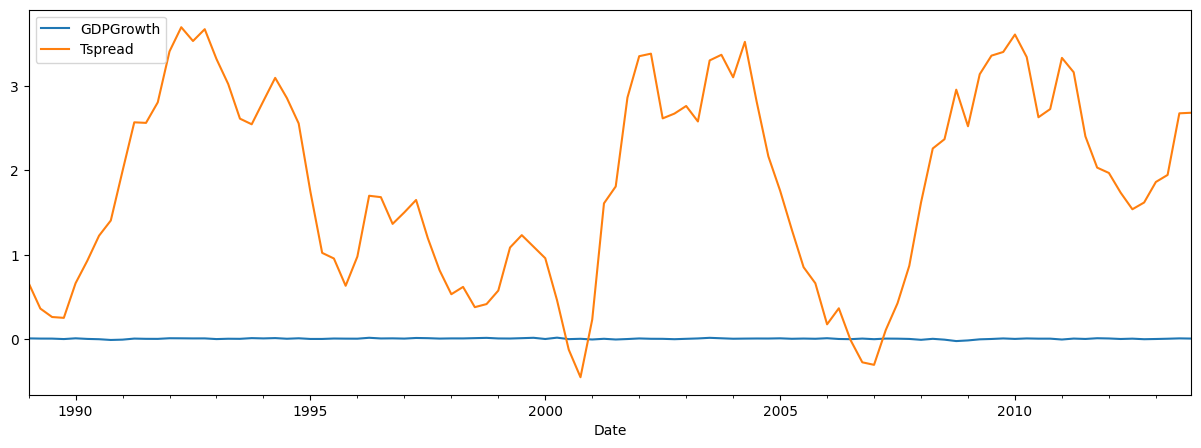

In [32]:
df1.loc[train_idx, 'Train Pred Graph'] = res.fittedvalues['GDPGrowth']
df1.loc[test_idx, 'Test Pred Graph'] = fcast.predicted_mean['GDPGrowth']

plot_cols = ['GDPGrowth', 'Train Pred Graph', 'Test Pred Graph']

df1.iloc[-100:][cols].plot(figsize = (15,5))